In [1]:
from torch_geometric.datasets import Planetoid
import torch
from torch_geometric.data import Data

In [2]:
dataset_cora = Planetoid(root='./cora/', name='Cora')
# dataset = Planetoid(root='./citeseer',name='Citeseer')
# dataset = Planetoid(root='./pubmed/',name='Pubmed')
print(dataset_cora[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(dataset_cora.num_node_features, 16, 'lstm')
        self.conv2 = SAGEConv(16, dataset_cora.num_classes, 'lstm')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.softmax(x, dim=1)

        return x
    
class GAT(nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset_cora.num_node_features, 16, heads=2)
        self.conv2 = GATConv(2*16, dataset_cora.num_classes, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.softmax(x, dim=1)

        return x

In [7]:
model = GAT()
print(model)

GAT(
  (conv1): GATConv(1433, 16, heads=2)
  (conv2): GATConv(32, 7, heads=1)
)


In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
data = dataset_cora[0].to(device)
print(data)

cuda:1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [12]:
model.train()
for epoch in range(200):
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    optimizer.zero_grad()
    loss.backward()
    scheduler.step(loss)
    optimizer.step()

    _, pred = torch.max(out[data.train_mask], dim=1)
    correct = (pred == data.y[data.train_mask]).sum().item()
    acc = correct/data.train_mask.sum().item()

    print('Epoch {:03d} train_loss: {:.4f} train_acc: {:.4f}'.format(
        epoch, loss.item(), acc))

Epoch 000 train_loss: 1.1844 train_acc: 0.9857
Epoch 001 train_loss: 1.1903 train_acc: 0.9857
Epoch 002 train_loss: 1.1836 train_acc: 0.9929
Epoch 003 train_loss: 1.1756 train_acc: 0.9929
Epoch 004 train_loss: 1.1865 train_acc: 0.9857
Epoch 005 train_loss: 1.1806 train_acc: 0.9929
Epoch 006 train_loss: 1.1847 train_acc: 0.9857
Epoch 007 train_loss: 1.1887 train_acc: 0.9857
Epoch 008 train_loss: 1.1868 train_acc: 0.9857
Epoch 009 train_loss: 1.1761 train_acc: 0.9929
Epoch 010 train_loss: 1.1771 train_acc: 1.0000
Epoch 011 train_loss: 1.1847 train_acc: 0.9857
Epoch 012 train_loss: 1.1698 train_acc: 1.0000
Epoch 013 train_loss: 1.1723 train_acc: 1.0000
Epoch 014 train_loss: 1.1733 train_acc: 1.0000
Epoch 015 train_loss: 1.1743 train_acc: 1.0000
Epoch 016 train_loss: 1.1744 train_acc: 1.0000
Epoch 017 train_loss: 1.1793 train_acc: 0.9929
Epoch 018 train_loss: 1.1695 train_acc: 1.0000
Epoch 019 train_loss: 1.1751 train_acc: 1.0000
Epoch 020 train_loss: 1.1778 train_acc: 1.0000
Epoch 021 tra

In [31]:
import numpy as np

# 示例数组
array1 = np.array([1, 2, 3, 4, 5])
array2 = np.array(['a', 'b', 'c', 'd', 'e'])

# 创建一个随机的索引数组
indices = np.random.permutation(len(array1))

# 使用随机索引打乱两个数组
shuffled_array1 = array1[indices]
shuffled_array2 = array2[indices]

print("打乱后的数组1:", shuffled_array1)
print("打乱后的数组2:", shuffled_array2)

打乱后的数组1: [1 4 5 3 2]
打乱后的数组2: ['a' 'd' 'e' 'c' 'b']


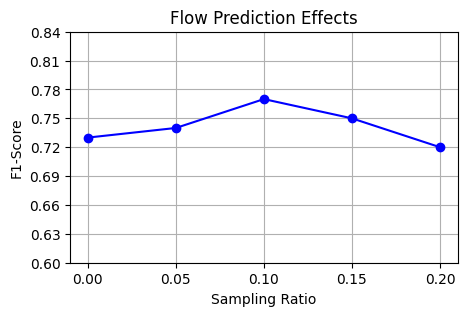

In [21]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([0, 0.05, 0.1, 0.15, 0.2])
b = np.array([0.73, 0.74, 0.77, 0.75, 0.72])

plt.figure(figsize=(5, 3))
plt.plot(a, b, marker='o', linestyle='-', color='b')
plt.title('Flow Prediction Effects')
plt.xlabel('Sampling Ratio')
plt.ylabel('F1-Score')
plt.grid(True)
plt.xticks(np.arange(0, 0.21, 0.05))
plt.yticks(np.arange(0.6, 0.86, 0.03))
plt.show()

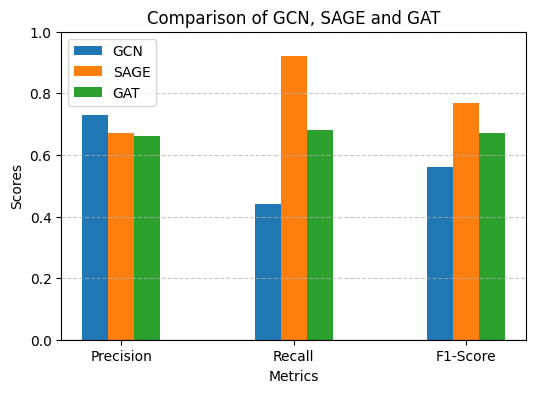

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
methods = ['GCN', 'SAGE', 'GAT']
metrics = ['Precision', 'Recall', 'F1-Score']
values = {
    'GCN': [0.73, 0.44, 0.56],
    'SAGE': [0.67, 0.92, 0.77],
    'GAT': [0.66, 0.68, 0.67]
}

# 设置柱形图位置
bar_width = 0.15
x = np.arange(len(metrics))

# 创建柱形图
fig, ax = plt.subplots(figsize=(6, 4))

# 绘制每个方法的柱形
for i, method in enumerate(methods):
    ax.bar(x + i * bar_width, values[method], bar_width, label=method)

# 添加标签和标题
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of GCN, SAGE and GAT')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.legend()

# 显示图形
plt.ylim(0, 1)  # 设定Y轴范围
plt.axhline(0, color='black', linewidth=0.8)  # 添加基线
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

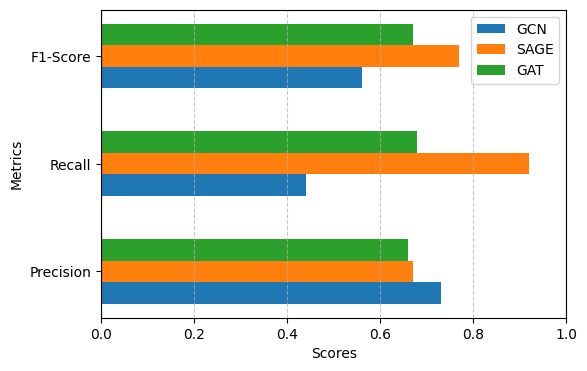

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
methods = ['GCN', 'SAGE', 'GAT']
metrics = ['Precision', 'Recall', 'F1-Score']
values = {
    'GCN': [0.73, 0.44, 0.56],
    'SAGE': [0.67, 0.92, 0.77],
    'GAT': [0.66, 0.68, 0.67]
}

# 设置柱形图位置
bar_width = 0.2
y = np.arange(len(metrics))

# 创建横向柱形图
fig, ax = plt.subplots(figsize=(6, 4))

# 绘制每个方法的横向柱形
for i, method in enumerate(methods):
    ax.barh(y + i * bar_width, values[method], bar_width, label=method)

# 添加标签和标题
ax.set_ylabel('Metrics')
ax.set_xlabel('Scores')
ax.set_yticks(y + bar_width)
ax.set_yticklabels(metrics)
ax.legend()

# 显示图形
plt.xlim(0, 1)  # 设定X轴范围
plt.axvline(0, color='black', linewidth=0.8)  # 添加基线
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [2]:
import json 
dataset_list = None
with open('/home/user/baitianrui/bpmn/LLMEnG/my-data/datasets5.json', 'r') as f:
    dataset_list = json.load(f)
sum_conditions = 0
for dataset in dataset_list:
    data_2_mask_single_signal_llm = dataset['data_2_mask_single_signal_llm']
    sum_conditions += data_2_mask_single_signal_llm.count('[condition]')
print(sum_conditions/68)

2.735294117647059


In [1]:
from transformers import BertTokenizer, BertModel
path = "/home/user/baitianrui/bpmn/model/safetensors/bert-base-uncased/"
tokenizer = BertTokenizer.from_pretrained(path)
model = BertModel.from_pretrained(path)